#### Los datasets de ratings disponibles, tras consultar la API InfoPelis, muestran a Amazon como la plataforma con mayor cantidad de peliculas, por lo tanto usaremos su información para el modelo de recomendación.
#### Previo a generar el modelo analicemos los datos que presenta el catálogo de Amazon, y los de sus usuarios, en busca de indicios a algunas consultas de negocio

In [3]:
import pandas as pd

from data.conexion_transformaciones import obtener_datos_plataforma, obtener_rating

pd.options.mode.chained_assignment = None

Leemos dataset de Amazon transformado previamente 

In [4]:
amazon_df = obtener_datos_plataforma('amazon')

In [7]:
amazon_df.describe(include='all',).iloc[:4]

,id,type,title,director,cast,release_year,rating,listed_in,description,duration_int,duration_type
count,9667,9667,9667,7585,8434,9667.0,9667,9667,9667,9667.0,9667
unique,9667,2,9650,5773,7926,NaN,24,518,9413,NaN,3
top,as1,movie,a bucket of blood,Mark Knight,Maggie Binkley,NaN,13+,drama,1,NaN,min
freq,1,7813,2,113,56,NaN,2116,986,15,NaN,7813


Notamos que campo listed_in (género del programa) presenta 518 valores distintos. Observemos sus valores 

In [8]:
amazon_df.listed_in.unique()[:20]

array(['comedy, drama', 'action, drama, suspense', 'documentary',
       'drama, fantasy', 'fantasy, kids', 'documentary, special interest',
       'comedy', 'action, science fiction, suspense', 'drama',
       'adventure, kids', 'horror, suspense', 'documentary, sports',
       'horror, science fiction', 'kids, special interest',
       'comedy, talk show and variety', 'science fiction', 'kids',
       'action, anime, comedy',
       'arts, entertainment, and culture, comedy, drama', 'tv shows'],
      dtype=object)

Como cada pelicula abarca varios géneros, debemos aplanar los valores para un análisis de frecuencia

In [9]:
from collections import defaultdict

appearance_groups = amazon_df.listed_in.dropna()

appearances = [item.strip() for group in appearance_groups for item in group.split(',')]

#diccionario con cantidad de apariciones para cada genero
theme = defaultdict(int)

for item in appearances:
  theme[item] += 1

In [10]:
#cantidad de generos
len(theme.keys())

31

Observemos distribución de géneros, tomemos los 20 primeros

In [11]:
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import gc #garbage collector

In [12]:
themes = pd.Series(theme)

prim20 = themes.sort_values(ascending=False).iloc[:20]

prim20

drama                        3686
comedy                       2099
action                       1657
suspense                     1501
kids                         1085
documentary                   993
special interest              980
horror                        875
romance                       674
animation                     547
arts                          483
and culture                   483
entertainment                 483
science fiction               457
international                 354
tv shows                      263
adventure                     259
western                       234
sports                        160
music videos and concerts     155
dtype: int64

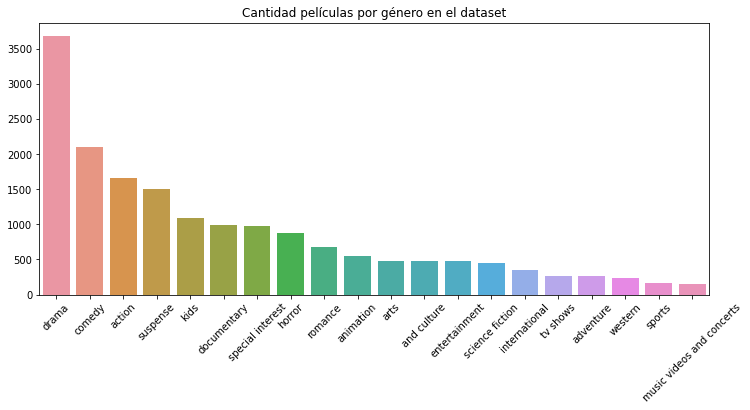

In [13]:
plt.figure(figsize=(12,5))

sns.barplot(x=prim20.index.values, y=prim20.values)

plt.xticks(rotation=45);

plt.title('Cantidad películas por género en el dataset');

Claramente drama duplica al resto de generos presentes en el dataset, seguido de comedia y acción, presentando un descenso curvado. 

Los restantes 10 generos (no mostrados en la gráfica) presentan cantidades menor igual al 1% del total de filas (100 peliculas de 9800 totales).

Notamos que campo rating (clasificación del programa) presenta 24 valores distintos, grafiquemos la distribucion de las clasificaciones de peliculas para observar su distribución

In [14]:
amazon_df.rating.unique()

array(['g', '13+', 'all', '18+', 'r', 'tv-y', 'tv-y7', 'nr', '16+',
       'tv-pg', '7+', 'tv-14', 'tv-nr', 'tv-g', 'pg-13', 'tv-ma', 'pg',
       'nc-17', 'unrated', '16', 'ages_16_', 'ages_18_', 'all_ages',
       'not_rate'], dtype=object)

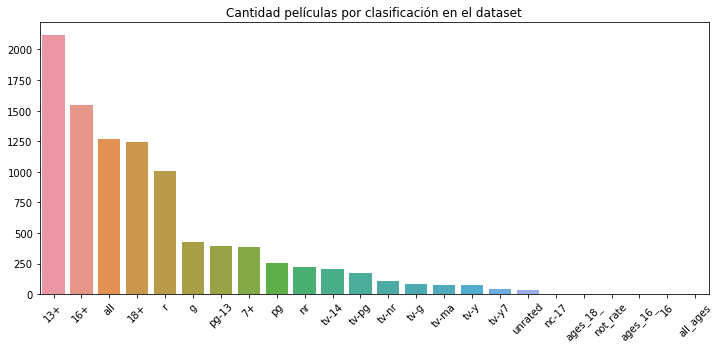

In [15]:
plt.figure(figsize=(12,5))

sns.barplot(x=amazon_df.rating.value_counts().index,y=amazon_df.rating.value_counts().values)

plt.xticks(rotation=45);

plt.title('Cantidad películas por clasificación en el dataset');

Vemos clasificación 13+ con alrededor de un 20% del total de registros (2000 de 9800 filas), seguido de cerca por 16+, con fuerte descenso a partir de 'g', menor al 5% del total

Concluímos que el catálogo de Amazon que adquirimos no representa equitativamente ni a los géneros ni a las clasificaciones de los programas.

Se orienta más hacia un publico adulto-juvenil (arriba de 13 años) con fuerte preferencia por género drama, seguido en menor medida de comedia y acción

#### Sistema de recomendación

Un sistema de recomendación (RS) es un algoritmo que predice la preferencia de los usuarios ante un cierto ítem. Hay dos elementos fundamentales en todo el proceso de RS: `usuarios` e `ítems`.

Los usuarios tienen preferencias para ciertos artículos, y estas preferencias deben extraerse de los datos. Los datos en sí se representan como una **`matriz de utilidad`**, dando para cada par usuario-ítem un valor que representa lo que se sabe sobre el grado de preferencia de ese usuario por ese artículo.

Esta matriz puede presentar lugares sin información sobre elecciones del usuario.
Nuestro objetivo es predecir todos los valores desconocidos en la matriz de utilidad. 


#### Filtro colaborativo

Se busca similitud entre los usuarios. Ya no nos importa extraer información del artículo que recomendamos, sino buscar similaridad entre los usuarios. Empleamos una descomposición UV.

Utilizaremos la **distancia** para determinar similitud de dos artículos



Para obtener los gustos de los usuarios de Amazon filtraremos los datasets de ratings, quedándonos con los registros que refieran a programas de Amazon

In [16]:
# nos conectamos al data lake y traemos dataset 1 de ratings
df = obtener_rating(1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1500000 non-null  int64  
 1   rating     1500000 non-null  float64
 2   timestamp  1500000 non-null  int64  
 3   movieId    1500000 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 45.8+ MB


In [18]:
id_pelis = amazon_df.id.unique()

pelis = df[df['movieId'].isin(id_pelis)]

pelis.reset_index(inplace=True,drop=True)

pelis

,userId,rating,timestamp,movieId
0,1,1.0,1425941529,as680
1,1,5.0,1425941556,as9500
2,1,4.0,1425942148,as3004
3,1,5.0,1425941593,as6112
4,1,4.0,1425942007,as5517
...,...,...,...,...
629039,15424,2.5,1370210004,as9011
629040,15424,2.0,1369664503,as296
629041,15424,4.0,1370209959,as8698
629042,15424,3.5,1369586045,as3663


In [19]:
#Nos conviene userid como string para contabilizar unicos
pelis['userId'] = pelis['userId'].astype('str')

Continuamos con los demás ratings y los juntamos en un dataset que filtró solo los ratings de Amazon

In [20]:
for i in range(2,9):

  df = obtener_rating(i)
  
  pelis2 = df[df['movieId'].isin(id_pelis)]
  
  pelis2['userId'] = pelis2['userId'].astype('str')
  
  pelis = pd.concat([pelis,pelis2])

In [21]:
len(pelis)

4631357

In [22]:
del df
gc.collect()

15358

In [23]:

amazon_ratings = pelis.reset_index(drop=True)

amazon_ratings.head()

,userId,rating,timestamp,movieId
0,1,1.0,1425941529,as680
1,1,5.0,1425941556,as9500
2,1,4.0,1425942148,as3004
3,1,5.0,1425941593,as6112
4,1,4.0,1425942007,as5517


In [25]:
amazon_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4631357 entries, 0 to 4631356
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   rating     float64
 2   timestamp  int64  
 3   movieId    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 141.3+ MB


Desechemos la columna timestamp, pues no la necesitamos 

In [26]:
amazon_ratings.drop('timestamp',inplace=True,axis=1)

In [28]:
amazon_ratings.describe(include='all')

,userId,rating,movieId
count,4631357,4.631357e+06,4631357
unique,112461,NaN,9667
top,45811,NaN,as4197
freq,7635,NaN,576
mean,NaN,3.532697e+00,NaN
std,NaN,1.059573e+00,NaN
min,NaN,5.000000e-01,NaN
25%,NaN,3.000000e+00,NaN
50%,NaN,3.500000e+00,NaN
75%,NaN,4.000000e+00,NaN


Vemos 112000 usuarios de Amazon que calificaron 9600 películas.
Además los ratings van desde 0 a 5

Veamos la cantidad de calificaciones de películas por usuario


In [29]:
amazon_ratings_by_users = amazon_ratings.groupby(['userId']).count()

amazon_ratings_by_users.head()

,rating,movieId
userId,,
1,10,10
10,7,7
100,1,1
1000,2,2
10000,5,5


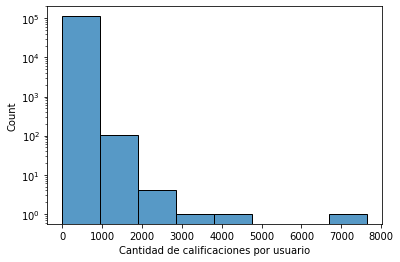

In [31]:
sns.histplot(data=amazon_ratings_by_users.rating,log_scale=(False,True),bins=8)

plt.xlabel('Cantidad de calificaciones por usuario');

Vemos que 100000 usuarios, el 90% del total, realizan menos de 1000 calificaciones, de un total de 9000 posibles. 
Da la sensación de que cada uno de estos consume menos del 10% del catálogo de Amazon



Text(0.5, 0, 'Valor calificación')

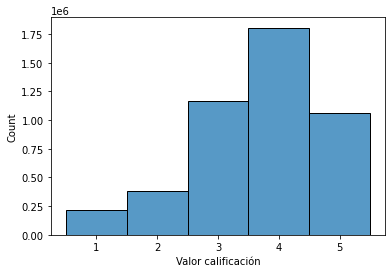

In [35]:
sns.histplot(amazon_ratings.rating, binwidth=1)

plt.xlabel('Valor calificación')

De 4 millones de calificaciones, 1.75 millones son de 4 estrellas, alrededor de 1 millon son de 5 estrellas, menos de 250 mil con 1 estrella.

Veamos cuantas calificaciones hay por película

In [36]:
amazon_ratings_by_movies = amazon_ratings.groupby(['movieId']).count()

amazon_ratings_by_movies.sort_values('userId', ascending = False, inplace = True)

amazon_ratings_by_movies['Vistos'] = amazon_ratings_by_movies['userId']

amazon_ratings_by_movies.drop(columns = ['userId','rating'], inplace = True)

In [37]:
amazon_ratings_by_movies.head(5)

,Vistos
movieId,
as4197,576
as9065,560
as848,558
as9469,556
as6998,556


In [38]:
amazon_ratings_by_movies.describe()

,Vistos
count,9667.000000
mean,479.089376
std,22.095776
min,396.000000
25%,464.000000
50%,479.000000
75%,494.000000
max,576.000000


Las audiciones están parejas, la película con menor audiencia presenta 394 calificaciones y la de mayor audiencia presenta 573 calificaciones.

Como hemos analizado al inicio, de las 9800 peliculas que ofrece Amazon abunda el género Drama y son orientadas a un público adulto-juvenil. Es probable que una recomendación tenga estas características.

# Machine Learning

Emplearemos la librería `Surprise` para modelar el sistema de recomendación.

Tendremos que llevar nuestro dataset al formato con el que trabaja esta librería.

In [ ]:
import sys
#!conda install -c conda-forge scikit-surprise 
!pip install scikit-learn

!pip install scikit-surprise 

from surprise import Dataset

from surprise import Reader

from surprise.model_selection import train_test_split

In [40]:
reader = Reader()

Nos conviene emplear datos de usuarios con la mayor cantidad de calificaciones, pues los que realizaron menor cantidad no aportarán mucha información al algoritmo.

In [41]:
amazon_ratings_by_users.sort_values('rating',ascending=False).tail()

,rating,movieId
userId,,
67975,1,1
12312,1,1
112767,1,1
51513,1,1
9999,1,1


Eliminaremos los usuarios que realizaron menos de 20 calificaciones, como vemos hay varios con 1 solo aporte

In [42]:
less_than20 = amazon_ratings_by_users[amazon_ratings_by_users.rating < 20].index.values

In [43]:
len(less_than20)

66904

In [44]:
most_active_users = amazon_ratings[-amazon_ratings['userId'].isin(less_than20)]

In [45]:
len(most_active_users)

4109910

In [51]:
#shufleamos 
most_active_users = most_active_users.sample(frac=1)


In [52]:
N_filas = 200000 # Limitamos el dataset a N_filas para minimizar el tiempo y recursos de calculo

data = Dataset.load_from_df(most_active_users[['userId','movieId','rating']][:N_filas], reader)

Usaremos un modelo de Singular Value Decomposition

In [53]:
from surprise import SVD

Entrenamos el modelo probando distintas combinaciones de hiperparámetros

In [94]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005], 'reg_all': [0.002, 0.02, 0.2]}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1,refit=True)

grid_search.fit(data)

Observamos performance del mejor modelo sobre nuestro dataset

In [97]:
print(grid_search.best_score['rmse'])

print(grid_search.best_params['rmse'])

1.017196074170192
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


Usando el modelo obtenido recomendaremos peliculas a un usuario.

 Seleccionamos alguno que haya calificado con 4 o 5 estrellas

In [59]:
users_with4stars = amazon_ratings[amazon_ratings.rating >3]

In [66]:
usuario = users_with4stars.tail()['userId'].iloc[-1]

Tomamos películas a las que haya calificado con 4 o 5 estrellas

In [73]:
rating = 4   

df_user = amazon_ratings[(amazon_ratings['userId'] == usuario) & (amazon_ratings['rating'] >= rating)]

df_user = df_user.reset_index(drop=True)

df_user = df_user.merge(amazon_df, right_on='id', left_on='movieId')

Nos quedamos solo con las columnas que el modelo necesita

In [78]:
df_user = df_user[['userId','rating_x','movieId','title']]

df_user.head()

,userId,rating_x,movieId,title
0,124380,4.5,as9383,held up
1,124380,5.0,as1126,rudy ruettiger: the walk on
2,124380,4.0,as4403,acquainted
3,124380,5.0,as5724,devil's island
4,124380,5.0,as3030,blood & treasure


Creamos tabla de peliculas de Amazon que ofreceremos al usuario

In [88]:
#porción de catálogo de Amazon
recomendaciones_usuario = amazon_df.iloc[:4499].copy()

unnecessary_cols = [col for col in recomendaciones_usuario.columns.values if (col != 'title' and col != 'id')]

print(recomendaciones_usuario.shape)

recomendaciones_usuario = recomendaciones_usuario.set_index('id').drop(unnecessary_cols,axis=1)

recomendaciones_usuario.head()

(4499, 11)


,title
id,
as1,the grand seduction
as3,secrets of deception
as4,pink: staying true
as5,monster maker
as6,living with dinosaurs


Debemos extraer las películas que ya ha visto 

In [89]:
usuario_vistas = amazon_ratings[amazon_ratings['userId'] == usuario]

print(usuario_vistas.shape)

usuario_vistas.head()

(15, 3)


,userId,rating,movieId
4631342,124380,4.5,as9383
4631343,124380,5.0,as1126
4631344,124380,2.5,as1867
4631345,124380,4.0,as4403
4631346,124380,3.0,as2612


In [91]:
recomendaciones_usuario.drop(usuario_vistas.movieId, inplace = True,errors='ignore')

recomendaciones_usuario = recomendaciones_usuario.reset_index()

recomendaciones_usuario.head()

,id,title
0,as1,the grand seduction
1,as3,secrets of deception
2,as4,pink: staying true
3,as5,monster maker
4,as6,living with dinosaurs


Esperamos obtener posibles calificaciones que el usuario les otorgaría según el modelo que generamos 

In [98]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['id'].apply(lambda x: grid_search.predict(usuario, x).est)

In [99]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)

print(recomendaciones_usuario.head(10))

          id                                       title  Estimate_Score
1644  as1649                     missing 411: the hunted        4.068547
3118  as3126                                      beaten        4.067574
378    as380    the world's most breathtaking waterfalls        4.066081
1136  as1141                                 rodeo girls        4.011512
977    as981                            skulls and roses        4.002353
4071  as4079                             city of shadows        4.001239
2325  as2331                   go buster - awesome songs        3.978435
1450  as1455  nursery rhymes volume 4 by little baby bum        3.977857
3969  as3977                             almost an angel        3.974963
1573  as1578                                mr. reckless        3.973927


La columna estimate_score son puntajes que el usuario les daría a las peliculas, que aún no ha visto o calificado.

Hacemos una predicción de puntaje del usuario para una película del catálogo de Amazon al azar

In [106]:
import random

indices_pelis = amazon_df.id.index.values

index = random.choice(indices_pelis )

peli_recomendada = amazon_df.id.iloc[index]

grid_search.predict(usuario, peli_recomendada)

Prediction(uid='124380', iid='as5250', r_ui=None, est=3.4626708595973303, details={'was_impossible': False})